## Assignment A3a: Signals and Noise

Please follow the General Assignment Guidelines document on canvas under the Pages for completing this assignment.  When you have completed the assignment, please follow the Submission Instructions.

### Overview

This assignment focuses on a few fundamental concepts in signal processing.  In the previous assignment, the signals where discrete events like photons.  Here, we will look at continuous signals that have structure that extends over time with additive noise.

### Learning objectives

- explain and illustrate the discrete representation of a continuous signal
- explain aliasing and the Nyquist frequency
- explain the delta and step functions
- write functions to synthesize signals
- write functions that accept functions as arguments
- estimate the energy and power of a signal
- compute the signal to noise ratio
- generate signals with different levels of additive noise
- design closed analysis/synthesis loops for testing correctness

### Readings

The following material provides both background and additional context.  It linked in the Canvas page for this assignment.  Refer to these for a more detailed explanation and formal presentation of the concepts in the exercises.  Note that the readings contain a lot more material than what's needed for the exercises.  Feel free to skim or ignore the parts that aren't directly relevant.

- Dusenbery, D. B. (1992). *Sensory Ecology*. Chapter 5-3 Signal Processing.
- Prandoni and Vetterli (2008) *Signal Processing for Communications*.  Chapters 1 and 2.

***
## Exercises

In [2]:
import numpy as np
import math

from matplotlib import pyplot as plt

In [3]:
import functions as f # import my functions from A1b and A3a (functions in A3a are shown below)

### 1. Continuous signals and sampling

Discrete sampling of continuous signals has some implications that are important to appreciate.  The first is that the sampled signal is only a *representation* of the underlying continuous signal and it doesn't necessarily capture all the information.  It is easy to visualize this by making a plot that overlays the discrete samples on the continuous function.

### 1a. Sampled functions

Write a function
```
plot_sampled_function(g=sin; fs=1, tlim=(0,2π), tscale=1, tunits="secs")
```
which plots a function `g` with overlaid samples at sampling frequency `fs` over range `tlim`, which is scaled by `tscale` and is plotted in units of `tunits`.  The function should be plotted as a line, and the samples should be overlaid as a stem plot.  

Looking ahead to the next module on sound localization, we want to start getting used to thinking in terms of the time scale of the waveform and use examples that more relevant to biological perception.  Instead of the defaults (which are sensible for a generic function), use `tscale=10^3` and `tunits="msecs"` for your examples.  Note that this time scale only applies to the plot -- time as a function argument should be in seconds.  This is to have a clean separation between the information and the display of the information.

Plot two examples using a sine and gammatone functions.  You can re-use your code from A1b.

In [12]:
def plot_sampled_function(t:float=None, g=np.sin, f:float=None, fs:float=1, tlim:tuple=(0, 2*np.pi), tscale:float=1, tunits:str="secs"):
    # function over tlim
    T = np.linspace(tlim[0]*tscale, tlim[1]*tscale, f * (tlim[1]-tlim[0])) if t is None else t
    F = g(T, f=f) if f is not None else g(T)

    # sample
    F_s = F[0::fs]
    S = T[0::fs]

    # plot
    plt.stem(S, F_s,label="samples")
    plt.plot(T, F, c='b', label="signal")
    plt.title("Sampled Function")
    plt.xlabel(f"Time ({tunits})")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

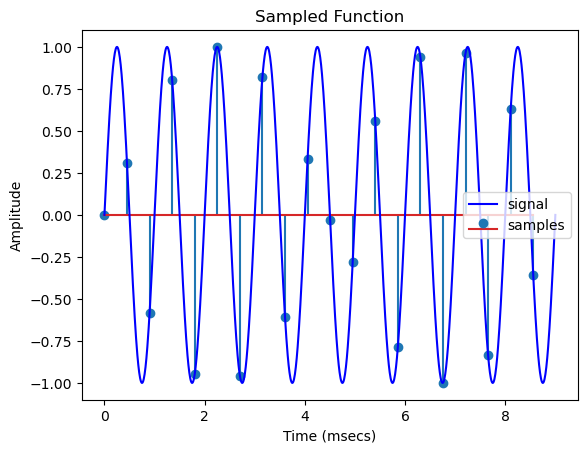

In [4]:
plot_sampled_function(g=f.sinewave,f=1000, fs=50, tlim=(0, 1), tscale=10^3, tunits="msecs")

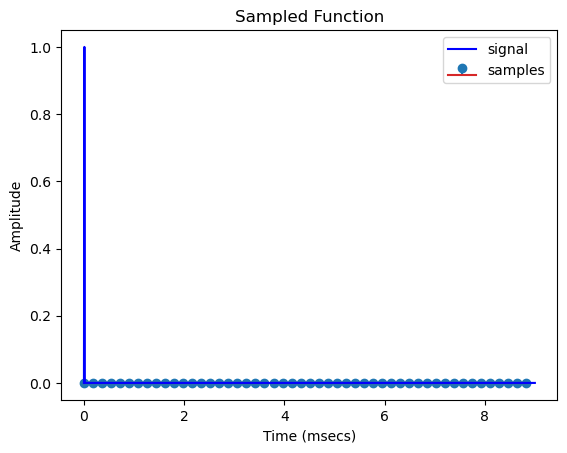

In [5]:
plot_sampled_function(g=f.gammatone, f=1000, fs=20, tlim=(0, 1), tscale=10^3, tunits="msecs")

### 1b. The Nyquist frequency and aliasing

The **Nyquist frequency** is defined as $f_s/2$, i.e. one half the sampling frequency.  It is the upper bound on the signal frequency that can be represented with sampling frequency $f_s$.

**Aliasing** occurs when the frequency of the function is greater than the sampling frequency, i.e. $f > f_s$.  In this case, sampling of a periodic function like sine can result in the appearance of sampling a function of much lower frequency than what's actually there.  To avoid aliasing artifacts when you digitally sample signals, you need to filter out all frequencies higher than the Nyquist frequency.

Use your function above to illustrate different types of sampling phenomena for these conditions:
1. A sine wave below Nyquist at a frequency that shows a few samples per period which unevenly distributed.
2. sine at Nyquist
3. cosine at Nyquist
4. cosine sampled above Nyquist frequency that clearly shows aliasing

Note that there are other common usages of the term "aliasing".  One is technical sense that we have just explained. Another is more colloquial and is used to describe any situation where the samples don't reflect the true underlying pattern.  It is commonly used to describe plotting a high frequency waveform where the discrete samples, even though there is no aliasing in a technical sense, show a more jagged structure than the actual analog pressure waveform, which is smooth.  Another common usage is when the details of a plot don't align well with the pixels.

In [14]:
# sine wave below Nyquist frequency
plot_sampled_function(g=np.sin, f=0.03, fs=0.2, tlim=(0, 2*np.pi))

TypeError: 'float' object cannot be interpreted as an integer

In [15]:
# sine wave at Nyquist frequency
plot_sampled_function(g=np.sin, f=0.1, fs=0.2, tlim=(0, 2*np.pi))

TypeError: 'float' object cannot be interpreted as an integer

In [16]:
# cosine at Nyquist frequency
plot_sampled_function(g=np.cos, f=0.1, fs=0.2, tlim=(0, 2*np.pi))

TypeError: 'float' object cannot be interpreted as an integer

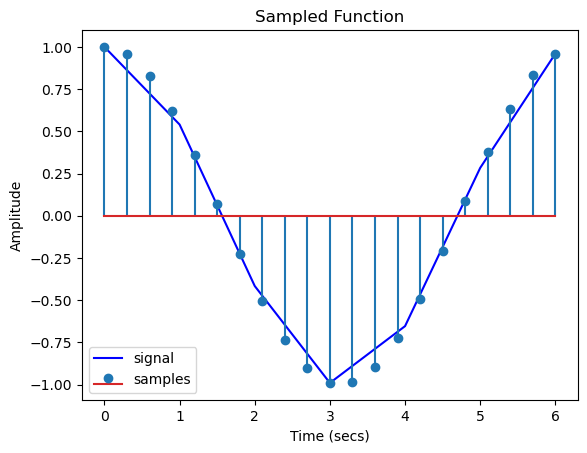

In [ ]:
# cosine above Nyquist frequency
plot_sampled_function(g=np.cos, f=1, fs=0.3, tlim=(0, 2*np.pi))

### 2. Signals

We have used functions like sine wave, Gaussian, Gabor, and gammatone.  Here we add two more functions to our library that will be useful for generating signals.

#### The delta function

The Dirac delta function is used to to model an impulse or discrete event as a brief impulse of energy.  The delta function is zero everywhere except at $t = 0$
$$
\delta(t) = \begin{cases}
\text{undefined} & t = 0\\
0 & t \neq 0
\end{cases}
$$

The value at zero is unbounded and undefined, but the integral is one

$$
\int_{-\infty}^\infty \delta(t) dt = 1
$$

We also have the property
$$
\int_{-\infty}^\infty f(t) \delta(t - \tau) dt = f(\tau)
$$

Another way to think about this is that $\delta(t-\tau)$ is zero everywhere except at $t = \tau$.  At that (infinitesimal) point, $f(t = \tau)$ is constant and so multiplies the integral, which is one.

#### The unit step function

The unit step function (also called the Heaviside step function) is used to indicate a constant signal that starts at $t=0$.  It is defined by
$$
u(t) = \begin{cases}
1 & t \geq 0\\
0 & t < 0 
\end{cases}
$$


### 2a. Delta and step functions

Write two functions `δ(t; fs=1)` and `u(t)` to implement the delta and unit step functions.  To use these functions to generate signals, which you can then sample, define them so that they accept a continuous time value.  

In the case of the delta function, we need define what we mean by "$t=0$", since that will depend on the sampling frequency.  To see why, note that we can model the sampling process as the integration of a function over the sample period as
$$
y = \int_{t-\Delta t/2}^{t+\Delta t/2} f(t) dt 
$$
where $y$ is the sample value, $\Delta t = 1/f_s$ is the sample period, and $t$ is the sample time which is centered on the period.  This means that if an impulse falls anywhere within a given sample period, the value of that sample will be one.  This is an idealized model.  Real-word impulses are rarely within the bounds of a sample.

In [ ]:
def delta(t=0, fs:float=1):
    # function of tlim
    c = 0
    T = np.array(t)

    # delta and return
    if T.size > 1:
        return np.array([1 if abs(t_-c) <= abs(c-1/(fs*2)) else 0 for t_ in T]) 
    else:
        return 1 if abs(t) < abs(c-1/(fs*2)) else 0

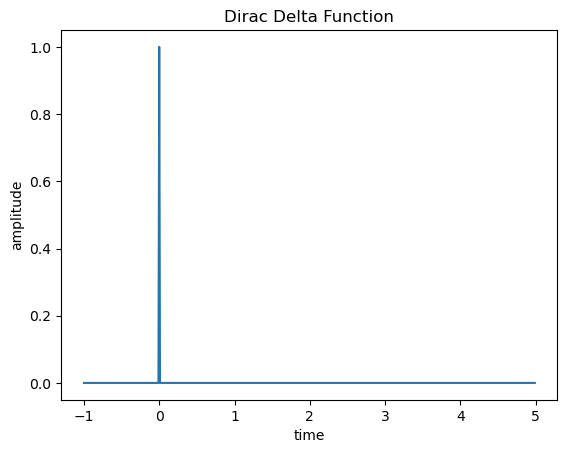

In [ ]:
T = np.arange(-1, 5, 0.01)
F = delta(T, fs=100)

plt.plot(T, F)
plt.xlabel("time")
plt.ylabel("amplitude")
plt.title("Dirac Delta Function")
plt.show()

In [ ]:
def u(t=0):
    # function of tlim
    c = 0
    T = np.array(t)

    # unit step
    return np.array([1 if t_ >= c else 0 for t_ in T]) if T.size > 1 else 1 if t >= c else 0

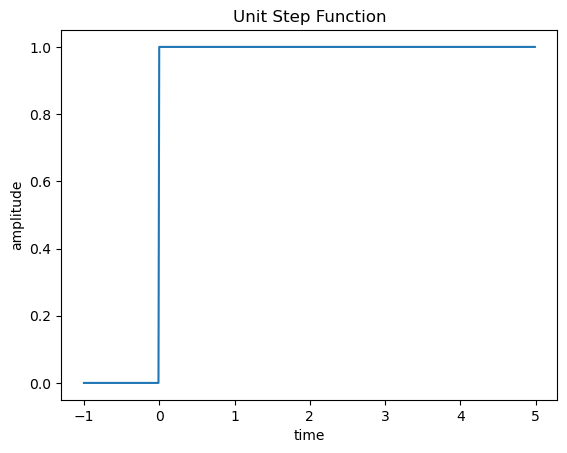

In [ ]:
T = np.arange(-1, 5, 0.01)
F = u(T)

plt.plot(T, F)
plt.xlabel("time")
plt.ylabel("amplitude")
plt.title("Unit Step Function")
plt.show()

### 2b. `gensignal`

Illustrate these functions by writing a function `gensignal(t, g; τ, T)` that generates the values at time `t` of a signal defined by function `g`, which should be function of time.  Other arguments to `g` can be specified upon definition, e.g.
```
    x = gensignal(t, t -> gammatone(t; f=100); τ=0.025, T=0.1)
```
The signal should be delayed by `τ` and have duration limited to `T`, i.e. it has value $g(t-\tau)$ and is zero for $t < \tau$ and $t >= T + \tau$.  Note that $T + \tau$ is an *exclusive* limit, because the sample times are centered on the sample periods.  For example, a unit step function for $f_s=1$, $\tau=0$, and $T=2$ will have values one only at times 0 and 1 with sample periods that extend from $-0.5/f_s$ to $1.5/f_s$.

In [6]:
def gensignal(t, g=lambda t: np.sin(t), tau:float=0, T:float=0.1):
    # compute signal
    T_ = np.array(t)
    F = g(t=T_-tau)

    # double check signal and return
    return np.array([0 if T_[i] < tau or T_[i] >= T+tau else F[i] for i in range(len(T_))]) if T_.size > 1 else 0 if T_ < tau or T_ >= T+tau else F

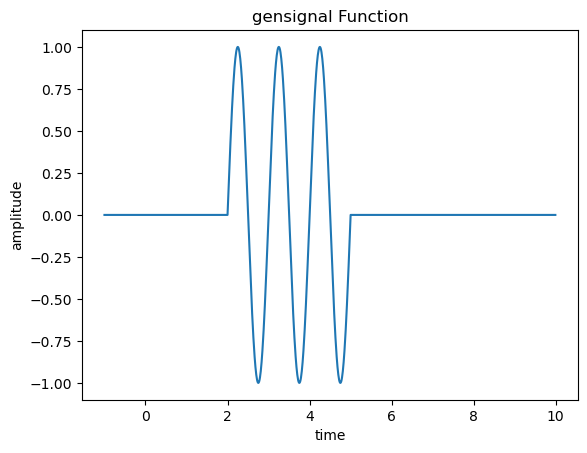

In [ ]:
T = np.arange(-1, 10, 0.01)
F = gensignal(T, g=lambda t: f.sinewave(t), tau=2, T=3)

plt.plot(T, F)
plt.xlabel("time")
plt.ylabel("amplitude")
plt.title("gensignal Function")
plt.show()

### 3. Noise and SNR

It is useful to have a generic way of describing the detectability of a signal.  In the Signal Detection assignment, we characterized this with the probability distributions of the events and the noise.   There, the events were discrete and we assumed they occurred within a sample.  For signals that extend over time, it is common to use the signal to noise ratio.

The signal to noise ratio ("SNR") is simply the power of the signal divided by the power of the noise.  So, naturally you ask, "What is power?"  That's a deep and complex question, but in the case of signals, power is average energy over a period.  The energy of a signal $x(t)$ is defined as

$$
E_x = \sum_{n=1}^N \Big| x[n] \Big|^2
$$

Here we will assume that $n$ sums over the extent of the signal, e.g. a sound of length $N$.  Thus, the energy is the same as the squared norm $||x||^2$ we used in A1b. The power of $x$ is then

$$
P_x = \frac{1}{N} \sum_{n=1}^N \Big| x[n] \Big|^2 = \sigma^2_x
$$

where $[n]$ indicates 1-based array indexing rather than a discrete time value of the function $x(t)$.  Note that for zero mean, the power is equivalent to variance.

For a signal in additive noise

$$
y[t] = x[t] + ϵ[t]
$$

the SNR is simply

$$
\frac{P_x}{P_ϵ}
$$

It is almost always expressed on a logarithmic scale in units of decibels (dB)

$$
\begin{aligned}
{\rm dB~SNR} &= 10 \log_{10}(P_x / P_ϵ) \\
             &= 20 \log_{10}(\sigma_x / \sigma_ϵ) \\
\end{aligned}
$$

Note that this implicitly assumes that we know the extent of the signal (to calculate $P_x$) or that it is **stationary** in time, i.e. the signal's structure doesn't change over time and extends throughout the period of analysis.  Structure could be described by the frequency content or by a probability distribution.

#### Peak Signal Noise Ratio

A related concept, which we won't use here, but is used more often in image processing, is peak signal to noise ratio or PSNR.  Many signals have limited extent which we don't know a priori, e.g. a feature in an image.  In this case, it makes sense to use the maximum value to approximate the best (or peak) SNR, i.e. the point where the signal is strongest.  

Since we don't know the signal, we also don't know the noise, so a second approximation is to assume that the signals are sparse (rarely occurring).  In this case, the power (or variance) of the noise can be approximated with the variance of the observed waveform $y$, because we assume it is dominated by the noise.  An example in images would be sparse features on a smooth background where the variance would be dominated by the "smooth" background, and so would approximate the underlying noise.

Putting these concepts together (and again assuming zero mean) gives

$$
\begin{aligned}
{\rm PSNR} &= 10\log_{10} \left( \frac{\max_t(y[t])^2}{\sigma^2_y} \right) \\
           &= 20\log_{10} \left( \frac{\max_t(y[t])}{\sigma_y} \right)
\end{aligned}
$$


### 3a. `energy`, `power`, and `snr`

Write functions `energy(x)`, `power(x)`, `snr(Ps, Pn)` for the definitions above.

In [38]:
def energy(x):
    # raise all elements to 2nd power and sum all elements
    X = np.array(x)
    return np.sum(np.power(X, 2))

In [39]:
def power(x):
    X = np.array(x)
    return energy(x)/X.size

In [40]:
def snr(Ps, Pn):
    return 10 * np.log10(Ps / Pn)

### 3b. Noisy signals

Write a function `y = noisysignal(t; g, τ, T, σ)` that generates a sample at time `t` of a signal plus additive Gaussian noise.  Like above, the signal is delayed by `τ` has duration `T`.  `σ` specifies the standard deviation of the noise.  Show examples with a sinewave, step, and gammatone.

In [4]:
def noisysignal(t, g:lambda t: np.sin(t), tau:float=0.25, T:float=1, sigma:float=0.05):
    # gensignal for range t
    T_ = np.array(t)
    F = gensignal(t=T_, g=g, tau=tau, T=T)

    # generate noise
    N = np.random.normal(loc=0, scale=sigma, size=T_.size)
    return np.add(F, N)

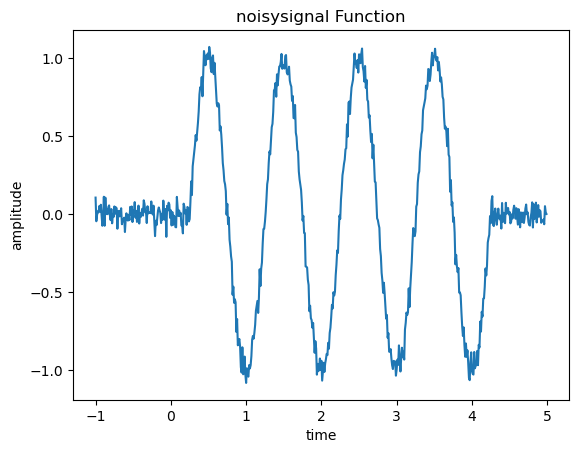

In [ ]:
T = np.arange(-1, 5, 0.01)
F = noisysignal(t=T, g=lambda t: f.sinewave(t), tau=0.25, T=4, sigma=0.05)

plt.plot(T, F)
plt.xlabel("time")
plt.ylabel("amplitude")
plt.title("noisysignal Function")
plt.show()

### 3c. Noise level specified by SNR

In 3b, we added noise that had a fixed variance.  Here we want to generate a signal that has a noise level specified by an SNR.  Since the SNR is the average signal energy, it 
depends on the whole signal.  Thus, to calculate the noise level needed to achieve a specified SNR, we need to define a function that accepts an array as input and also the location of the signal in the array.

Write a function
```
σ = snr2sigma(; x, xrange=1:length(x), snr=10)
```
which, given array `x`, returns the standard deviation of additive Gaussian noise such adding noise at that level to `x` has an SNR of `snr` dB.  The optional argument `xrange` specifies location of the signal, i.e. the range over which to compute the signal power.  It should default to the whole signal.

Note that calculating the signal power over the whole waveform when the signal is only present in part of the waveform would lead to a biased result.  Why is this?  Illustrate this by contrasting, the resulting waveforms produced with and without knowledge of signal location.

In [13]:
def snr2sigma(X:np.array, xrange:tuple=None, snr:float=10):
    xrange = (0, X.size) if xrange is None else xrange
    return np.std(X[xrange[0]:xrange[1]]) / 10**(snr / 20)

In [ ]:
# gen signal
T = np.arange(0, 10*np.pi, 0.01)
F = gensignal(t=T, g=lambda t: np.sin(t), tau=5, T=8)

# calc sigma over entire range and only signal range
print(f"sigma over entire range: {snr2sigma(F, snr=20)}")
print(f"sigma over signal range: {snr2sigma(F, xrange=(500, 800), snr=20)}")

sigma over entire range: 0.035794508772523895
sigma over signal range: 0.028907122077838198


### 3d. Estimating SNR

One of the challenges in developing algorithms for perceptual computations is that we rarely know the ground truth, and we often don't have control over the signal structure or real world conditions.  It is therefore useful to develop methods for synthesis.  In that spirit, we will "complete the loop" and estimate the SNR from a waveform.

Write a function `extent(y; θ=0.01)` that returns a range from the first to last index where the absolute value of array `y` exceeds threshold `θ`, which is specified as a fraction of the maximum absolute value.

Show that is produces the correct index range for a known case, and use it to estimate the SNR for a synthesized signal with known SNR.

In [37]:
def extent(Y, theta:float=0.01):
    # optimize threshold
    max = 0
    Y = np.abs(Y)
    for y in Y:
        if y > max:
            max = y
    t = theta * max

    # return start and end indices
    i = np.where(Y > t)[0]
    return (i[0], i[-1])

In [ ]:
# find sigma for snr of 10
T = np.arange(1, 10*np.pi, 0.01)
F = gensignal(t=T, g=lambda t: np.sin(t), tau=5, T=20)
print(f"estimated sigma for snr of 10: {snr2sigma(F, snr=20)}")

estimated sigma for snr of 10: 0.05675367515067077


In [ ]:
# estimate SNR for known signal
T = np.arange(-1, 10*np.pi, 0.01)
F = noisysignal(t=T, g=lambda t: np.sin(t), tau=5, T=20, sigma=0.0567)

# find signal
s, e = extent(Y=F, theta=0.25)
print(f"Signal found between indices [{s}, {e}]")

# separate signal from noise
F_s = F[s:e]
F_n = np.concatenate((F[0:s], F[e:-1]))

# calc snr
esnr = snr(Ps=power(F_s), Pn=power(F_n))
print(f"Estimated SNR: {esnr}")

Signal found between indices [625, 2599]
Estimated SNR: 20.550453504393012


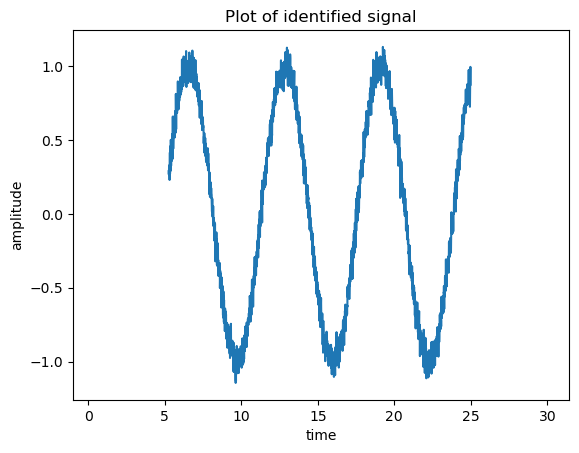

In [ ]:
plt.plot(T[s:e], F[s:e])
plt.xlim([-1, 10*np.pi])
plt.xlabel("time")
plt.ylabel("amplitude")
plt.title("Plot of identified signal")
plt.show()

### 4. Grand synthesis

One measure of the quality of your code design is the ease and flexibility of expressing new ideas.  To test this, use your functions to synthesize a waveform composed of random, normalized gammatones plus some level of Gaussian noise.

$$
\begin{aligned}
\tau_i & \sim \text{uniform}(0, T) \\
   f_i & \sim \text{uniform}(f_{\rm min}, f_{\max}) Hz
\end{aligned}
$$

The amplitudes $A_i$ can be constant or follow a distribution.  

Synthesize a several second waveform and export it to a .wav file.  What does it sound like?  Feel free to experiment with different parameters and distributions.

In [ ]:
# import packages
from scipy.io import wavfile

In [ ]:
# set the parameters
fs = 44100 # Hz
num = 10 # gammatones

filename = "out.wav"

In [ ]:
# times for plotting
T = np.linspace(0, 3, 3*fs+1)

# parameters to create gammatones
delays = [np.random.uniform(0, 3) for i in range(num)]
freqs = [np.random.uniform(10, 10000) for i in range(num)]

# generate the signals
S_i = np.array([noisysignal(t=T, g=lambda t: f.sinewave(t=t, f=freqs[i]), tau=delays[i], T=3) for i in range(num)])

# add signals
S = S_i[0]
for i in range(1, num, 1):
    S = np.add(S, S[i])

# normalize
S_norm = S / np.max(S)

# Write to wave file
wavfile.write(filename, fs, S_norm)

### Tests and self checks

You should write tests for your code and make plots to verify that your implementations are correct.  After you submit your draft version, take the self check quiz.  This will give you feedback so you can make corrections and revisions before you submit your final version.  Here are examples of the types of questions you can expect

- plotting different sampled functions given specified ranges and sampling frequencies
- conceptual questions regarding aliasing
- plotting the result of `gensignal` using specified functions and parameters
- calculating energy, power, and SNR for test waveforms
- plotting noisy signals using specified parameters
- demonstrating the `extent` function
- estimating SNR from a test waveform given the signal range
- providing an example of a synthesized sum of gammatones.

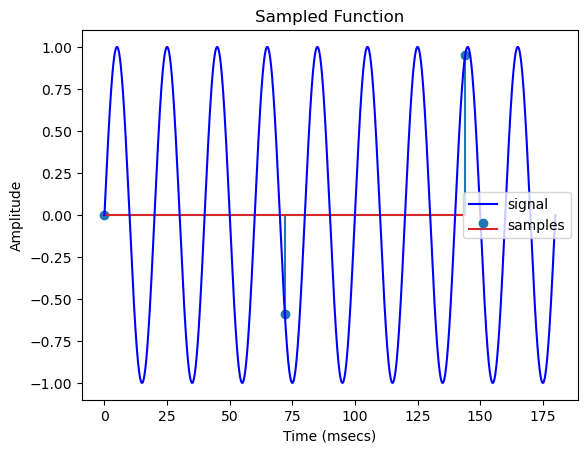

In [ ]:
# Q1 - Insert a plot of a 1000 Hz sine wave sampled at 8000 Hz.
plot_sampled_function(g=f.sinewave, f=1000, fs=8000, tlim=(0,20), tscale=10^3, tunits="msecs")

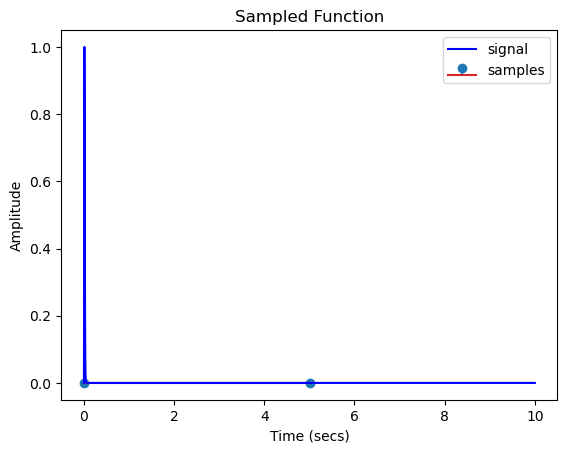

In [ ]:
# Q2 - Insert a plot of a 200 Hz gammatone sampled at 1000 Hz.
plot_sampled_function(g=f.gammatone, f=200, fs=1000, tlim=(0, 10))

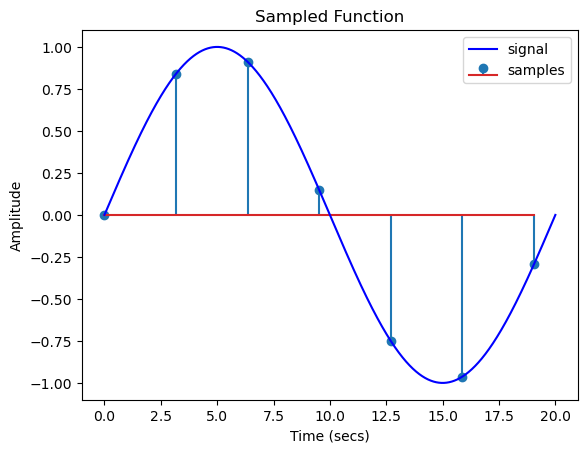

In [ ]:
# Q3 - Plot of a 315 Hz sine wave sampled at 1000 Hz.
plot_sampled_function(g=f.sinewave, f=315, fs=1000, tlim=(0, 20))

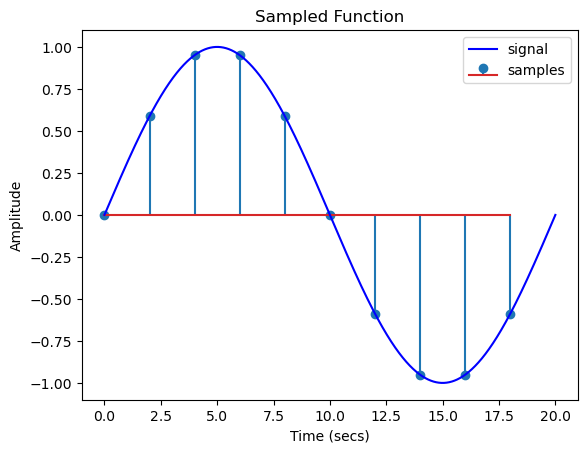

In [ ]:
# Q4 - Plot a 500 Hz sine wave sampled at 1000 Hz.
plot_sampled_function(f.sinewave, f=500, fs=1000, tlim=(0, 20))

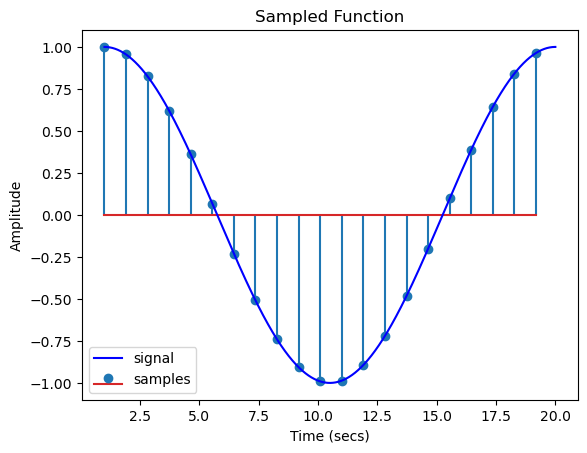

In [8]:
# Q5 - What is the apparent frequency of a 1100 Hz cosine wave sampled at 1000 Hz
plot_sampled_function(g=f.cosinewave, f=1100, fs=1000, tlim=(1, 20))
# 100 Hz

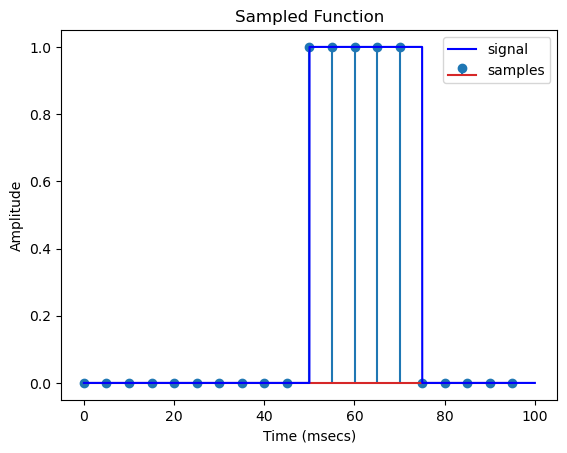

In [22]:
# Q6 - Plot a step function starting at 50 ms that is 25 ms in duration and sampled at 500 Hz.
T = np.linspace(0, 100, 10000)
plot_sampled_function(t=T, g=lambda t: gensignal(t=T, g=lambda t: f.u(t), tau=50, T=25), fs=500, tscale=10^3, tunits="msecs")

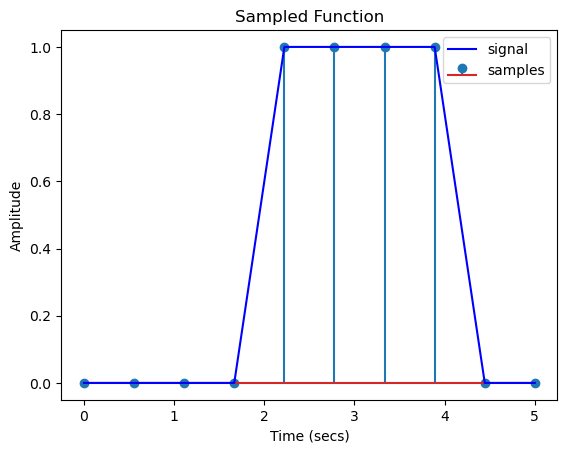

In [24]:
# Q7 - Plot a 5 second signal sampled at 1 Hz with a 2 sec step function starting at 2 seconds.
T = np.linspace(0, 5, 10)
plot_sampled_function(t=T, g=lambda t: gensignal(t=T, g=lambda t: f.u(t), tau=2, T=2), fs=1, tunits="secs")

In [63]:
# Q8 - What is the energy of a 1 Hz sine wave of duration 1 sec sampled at 100 Hz?  (to error margin of 0.001)
F = gensignal(t=np.linspace(0, 1, 1000), g=lambda t: f.sinewave(t, f=0.001))
F_s = F[0::100]
energy(F_s)

0.0

In [64]:
# Q9 - What is the power of a 1 Hz sine wave of duration 1 sec sampled at 100 Hz?  (to error margin of 0.001)
power(F_s)

0.0

In [ ]:
# Q10 - What is the power of a normalized gammatone of 100 Hz sampled at 1000 Hz for the time range between 5 and 40 ms (inclusive)? (to an error of 0.001)
F = f.gammatone(t=np)

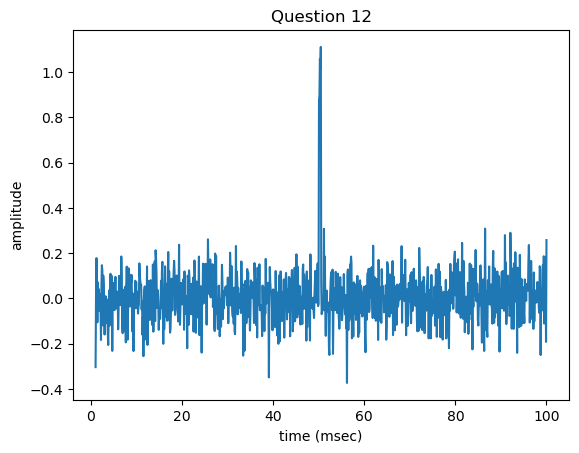

In [8]:
# Q12 - Plot a 100 ms waveform sampled at 1000 Hz with a delta function delayed by 50 ms with noise standard deviation of 0.1.
T = np.linspace(1, 100,  1000)
F = noisysignal(t=T, g=lambda t: f.delta(t), tau=50, sigma=0.1)

plt.plot(T, F)
plt.xlabel("time (msec)")
plt.ylabel("amplitude")
plt.title("Question 12")
plt.show()

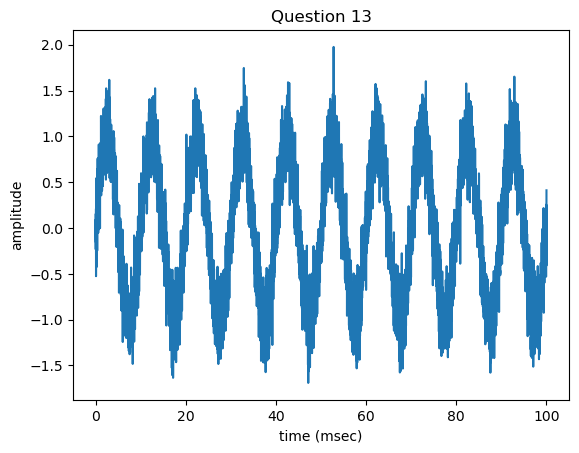

In [24]:
# Q13 - Plot 100 ms waveform sampled at 8000 Hz with a 100 Hz sine wave lasting for 100 ms with additive Gaussian noise at 10 dB SNR.
T = np.linspace(0, 100,  8000)
sigma = snr2sigma(f.sinewave(T, f=0.1), snr=10)
F = noisysignal(t=T, g=lambda t: f.sinewave(t, f=0.1), tau=0, T=100, sigma=sigma)

plt.plot(T, F)
plt.xlabel("time (msec)")
plt.ylabel("amplitude")
plt.title("Question 13")
plt.show()

0.15811388300841897


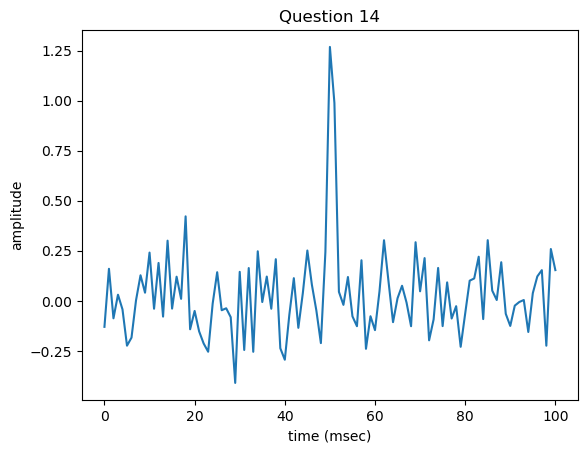

In [35]:
# Q14 - Plot a 2 ms step function with a delay of 50 ms in a waveform of 100 ms with 10 dB SNR calculated with knowledge of the signal location.
T = np.linspace(0, 100,  101)
sigma = snr2sigma(X=gensignal(t=T, g=lambda t: f.u(t), tau=50, T=2), xrange=(49, 51), snr=10)
print(sigma)
F = noisysignal(t=T, g=lambda t: f.u(t), tau=50, T=2, sigma=sigma)

plt.plot(T, F)
plt.xlabel("time (msec)")
plt.ylabel("amplitude")
plt.title("Question 14")
plt.show()

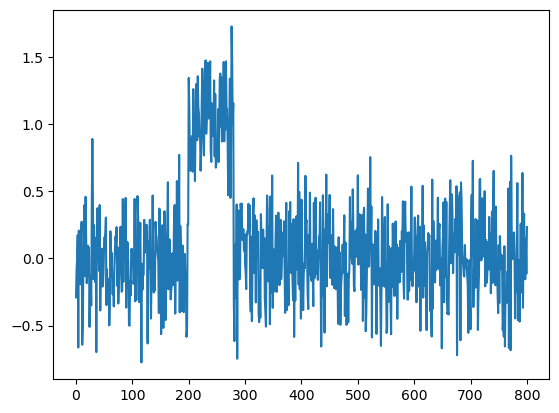

801
200 279
11.210778732846444


In [62]:
# Q15 - Read the 100 ms waveform "y" in the data file "A3a-testdata.h5".  What is the SNR of the pulse? (to an error of 0.5)
import h5py

file = h5py.File("A3a-testdata.h5", "r")
y = np.array(file["testdata"]["y"][()])

# plot for reference
plt.plot(np.arange(0, 801, 1), y)
plt.show()

print(y.size)

# signal and noise
s, e = extent(y, theta=0.52)
print(s, e)

# power for signal and noise
power_signal = power(y[s:e])
power_noise = power(np.concatenate((y[0:s], y[e:-1])))

# calc snr
esnr = snr(Ps=power_signal, Pn=power_noise)
print(esnr)

***
### Submission Instructions

Please refer to the Assignment Submission Instructions on canvas under the Pages tab.